# Introduction

This is the `Python` version of the notebook. For the `R` version, click [here](https://www.kaggle.com/ryanthomasallen/online-appendix-for-cae-2020-r)

This notebook is provided as supplementary material to the paper [Machine Learning for Pattern Discovery in Management Research](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3518780) by Prithwiraj Choudhury, Ryan Allen, and Michael Endres (Strategic Management Journal, 2020).

We assume users of this notebook are familiar with the paper, which lays out fundamental concepts of machine learning and the empirical setting. We also assume familiarity with Python, including the `pandas` and `scikit-learn` packages.

In order to preserve the anonymity of TECHCO and its employees, this notebook uses simulated data based on the real data used in the paper. The results in this notebook do not exactly match the results in the paper, but yield qualitatively similar findings.

# 1. Import Libraries and Data

In [5]:
# NUMPY / PANDAS
import numpy as np
import pandas as pd

# SCI-KIT LEARN
import sklearn
from sklearn.model_selection import (GroupKFold, GroupShuffleSplit, cross_validate, 
                                       RandomizedSearchCV,GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import log_loss, roc_curve, auc

#PDPbox
from pdpbox import pdp

# MATPLOTLIB
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# OTHER
from itertools import product
import copy
import graphviz

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

  Using cached PDPbox-0.2.1-py3-none-any.whl
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
  Running setup.py install for matplotlib: started
  Running setup.py install for matplotlib: finished with status 'error'
  Rolling back uninstall of matplotlib
  Moving to c:\users\hmk41\appdata\local\programs\python\python310\lib\site-packages\__pycache__\pylab.cpython-310.pyc
   from C:\Users\hmk41\AppData\Local\Temp\pip-uninstall-t69nj_b7\pylab.cpython-310.pyc
  Moving to c:\users\hmk41\appdata\local\programs\python\python310\lib\site-packages\matplotlib-3.5.2-py3.10-nspkg.pth
   from C:\Users\hmk41\AppData\Local\Temp\pip-uninstall-lo4ed3x7\matplotlib-3.5.2-

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [501 lines of output]
  Edit setup.cfg to change the build options
  
  BUILDING MATPLOTLIB
    matplotlib: yes [3.1.1]
        python: yes [3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC
                    v.1929 64 bit (AMD64)]]
      platform: yes [win32]
  
  OPTIONAL SUBPACKAGES
   sample_data: yes [installing]
         tests: no  [skipping due to configuration]
  
  OPTIONAL BACKEND EXTENSIONS
           agg: yes [installing]
         tkagg: yes [installing; run-time loading from Python Tcl/Tk]
        macosx: no  [Mac OS-X only]
  
  OPTIONAL PACKAGE DATA
          dlls: no  [skipping due to configuration]
  
  C:\Users\hmk41\AppData\Local\Programs\Python\Python310\lib\site-packages\setuptools\dist.py:287: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated, consider using implicit namespaces instead (PEP 420).
    warnings.war

ModuleNotFoundError: No module named 'pdpbox'

Import data.

In [1]:
df = pd.read_csv("simulated_TECHCO_data.csv")

NameError: name 'pd' is not defined

In [3]:
df

,time,training_score,logical_score,verbal_score,avg_literacy,location_age,distance,similar_language,is_male,emp_id,turnover
0,1,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
1,2,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
2,3,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
3,4,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
4,5,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
...,...,...,...,...,...,...,...,...,...,...,...
34447,34,4.525592,5,3,59.80474,9,0.294030,40.82030,1,1191,Stayed
34448,35,4.525592,5,3,59.80474,9,0.294030,40.82030,1,1191,Stayed
34449,36,4.525592,5,3,59.80474,9,0.294030,40.82030,1,1191,Stayed
34450,37,4.525592,5,3,59.80474,9,0.294030,40.82030,1,1191,Stayed


# 2. Preprocess and Partition Data

Convert variables to appropriate data types

In [4]:
df.time = df.time.astype(int)
df.is_male = df.is_male.astype(int)

Set index as `emp_id` and `time`

In [5]:
df.set_index(['emp_id','time'],drop=False,inplace=True)

Define the target, y as `turnover`. Set "Left" as the positive label.

In [6]:
df.loc[df['turnover']=='Stayed', 'turnover'] = '0 Stayed'
df.loc[df['turnover']=='Left', 'turnover'] = '1 Left'
df.turnover
y = df.turnover

Create `X`, the matrix of variables. Also use the list `cols` to set a consistent ordering of columns

In [7]:
X = df.drop(['turnover'],axis=1)
cols = ["time","training_score","avg_literacy","is_male","logical_score","verbal_score","location_age","distance","similar_language"]
X = X[cols]

Split to get indices for training/cross-validation and holdout test sets. We are using panel data (indices of `emp_id` and `time`) so we sample at the employee level rather than the observation level. If you are just sampling at the observation level, the code for this operation would be `GroupShuffleSplit(test_size=.3)` 

In [8]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.3,random_state=111).split(X,y,groups=df.emp_id))

Create training and test sets for `X`, `y`, and employee groupings

In [9]:
X_train, X_test = X.iloc[train_inds], X.iloc[test_inds]
y_train, y_test = y.iloc[train_inds], y.iloc[test_inds]
employee_train = df.emp_id.iloc[train_inds]

Define `folds`: a list of partitions in the data which will be used for cross-validation. Because we are using panel data where each employee has multiple observations, we sample at the employee level, not at the observation level. We use the function `GroupKFold` to split the data into folds grouped at the employee level. 

In [10]:
folds = list(GroupKFold(n_splits=10).split(X_train,y_train,employee_train))

Check Correlations. We should be aware that some algorithms may randomly substitute highly related variables for one another.

In [11]:
X_train_not_panel = X_train[X_train.time==1].drop(columns="time")
X_train_not_panel.corr()

,training_score,avg_literacy,is_male,logical_score,verbal_score,location_age,distance,similar_language
training_score,1.000000,0.099826,0.015493,0.004203,0.075785,0.069719,0.008875,-0.023459
avg_literacy,0.099826,1.000000,-0.123149,-0.094397,0.065413,-0.054087,-0.311901,0.131742
is_male,0.015493,-0.123149,1.000000,-0.063938,-0.028733,0.004991,0.091025,-0.021132
logical_score,0.004203,-0.094397,-0.063938,1.000000,0.322617,0.039691,0.006847,-0.006635
verbal_score,0.075785,0.065413,-0.028733,0.322617,1.000000,0.079222,-0.094231,0.010532
location_age,0.069719,-0.054087,0.004991,0.039691,0.079222,1.000000,0.278709,-0.304649
distance,0.008875,-0.311901,0.091025,0.006847,-0.094231,0.278709,1.000000,-0.665042
similar_language,-0.023459,0.131742,-0.021132,-0.006635,0.010532,-0.304649,-0.665042,1.000000


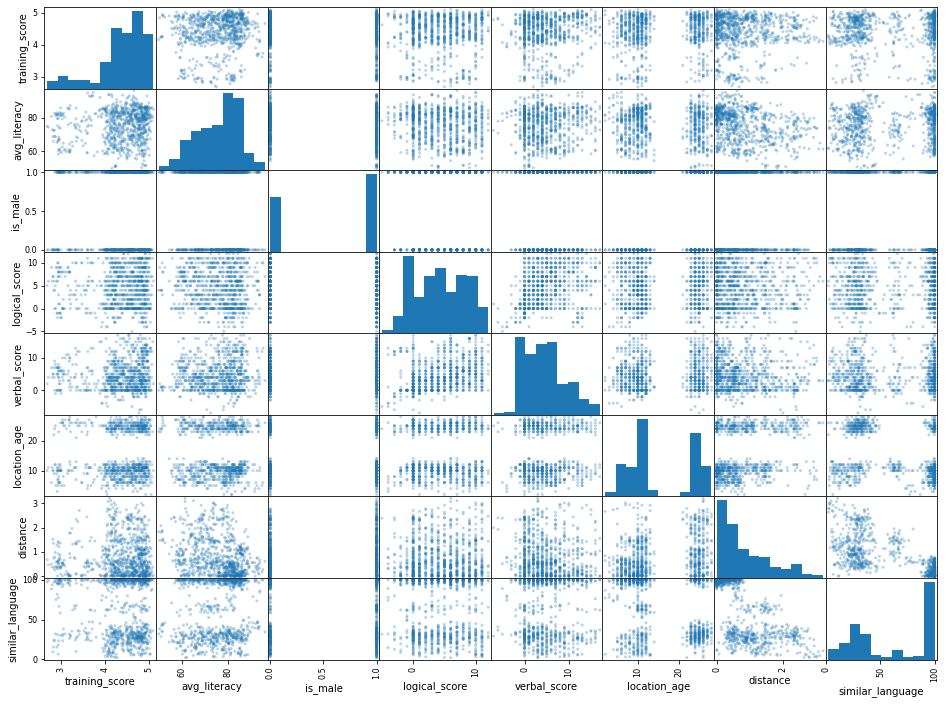

In [12]:
pd.plotting.scatter_matrix(X_train_not_panel,figsize=(16,12),alpha=0.3);

# 3. Define Custom Visualization Functions

This section defines the custom visualization functions for partial dependence plots and ROC curves that we used in the paper. You can also use off-the-shelf packages, such as the `pdpbox` package.

### Function for Plotting the ROC Curve
![](http://)![](http://)`plot_roc()` takes predictions (`y_predictions`), ground truth (`y_true`), and the name of the model (`name`) as arguments. It returns a plot of an ROC curve.

In [13]:
def plot_roc(y_predictions,y_true,name,pos_label):
    fpr,tpr,thresholds = roc_curve(y_true,y_predictions,pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    plt.title(name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### One-way Partial Dependence Plot Function with overlaid Individual Conditional Expectation (ICE) Plot 
`pdplot()` takes a dataframe (`X`), the estimator (`model`), the name of the variable to plot (`var_name`), and the number of desired samples to plot (`n`). It returns a partial dependence plot, which plots how the model predicts each sampled observation's predicted probability of turnover over the range of possible values of the plotted variable. It also includes `n` individual ICE lines.  Note the argument `which_class`, which tells the function to predict probabilities for a specific class label (in our case, "Left").
  
**For the off-the-shelf function for plotting partial dependence and ICE plots, use the `pdp_plot()` function from `pdpbox` package.**

In [14]:
def pdplot(X, model, n, var_name,categorical_var=False,which_class = 1):        
    X_copy = copy.deepcopy(X)
    #For the continuous variables that will be plotted, create 40-interval arrays.
    if categorical_var == False:
        var_grid_vals = np.linspace(X_copy[var_name].min(), X_copy[var_name].max(), num=40)
    #For the categorical variables that will be plotted, create array of the unique values
    if categorical_var == True:
        var_grid_vals = list(set(X_copy[var_name]))
    
    samples=np.random.choice(len(X_copy), n, replace=False)
    
    predictions = pd.DataFrame()
      
    f=plt.figure()
    
    for sample in samples:
        x_vals = list()
        for i in var_grid_vals:
            X_copy[var_name]=i
            y_hat=model.predict_proba(X_copy.iloc[(sample-1):sample])[:,which_class][0]
            y_hat_log_odds = np.log(y_hat/(1-y_hat))
            predictions=predictions.append({'sample':sample,'x_val':i,'pred':y_hat_log_odds},ignore_index=True)
        sample_preds = predictions[predictions['sample']==sample]
        plt.plot(sample_preds.x_val, sample_preds.pred, c='C1', alpha=1.0, linewidth=0.1)
        
    preds_grouped = predictions.groupby(['x_val']).mean().reset_index()
    plt.plot(preds_grouped.x_val, preds_grouped.pred, c='C0', linestyle='--')
    plt.ylabel(r'Log Odds of Turnover Probability (log $\frac{h_\theta(x)}{1-h_\theta(x)}$)')
    plt.xlabel(var_name)
    plt.ylim(-8,0)

### Two-way Partial Dependence Plot function
`plot_twoway_pdp()` takes a dataframe (`X`), the estimator (`model`), the name of the variable to plot on the x-axis (`var1_name`), and the name of the variable to plot on the y-axis (`var2_name`). The function returns a two-way PDP, which displays the model's predicted probability of turnover for each point across the range of 40 values for two variables (40\*40 = 1600 points total).    
  
The argument `which_class` tells the function to predict probabilities for a specific class label (in our case, "Left").
  
**For an off-the-shelf function for plotting two way partial dependence use the `pdp_interact_plot()` function from `pdpbox` package.**

In [15]:
def plot_twoway_pdp(X,model,var1_name,var2_name,categorical_var1=False,categorical_var2=False,
                 var1_min=None,var1_max=None,
                 var2_min=None,var2_max=None,
                 which_class = 1):
    #Set the min and max value to plot for both variables. Default is the min and max of the variable
    if var1_min is None:
        var1_min=X[var1_name].min() 
    if var1_max is None:
        var1_max=X[var1_name].max() 
    if var2_min is None:
        var2_min=X[var2_name].min()
    if var2_max is None:
        var2_max=X[var2_name].max() 
        
    X_copy = copy.deepcopy(X)
    
    #For the continuous variables that will be plotted, create 40-interval arrays.
    if categorical_var1 == False:
        var1_grid_vals = np.linspace(var1_min, var1_max, num=40)
    if categorical_var2 == False:
        var2_grid_vals = np.linspace(var2_min, var2_max, num=40)
        
    #For the categorical variables that will be plotted, create array of the unique values
    if categorical_var1 == True:
        var1_grid_vals = list(set(X_copy[var1_name]))
    if categorical_var2 == True:
        var2_grid_vals = list(set(X_copy[var2_name]))
    
    predictions_from_grid = list()
    x_vals = list()
    y_vals =list()
    
    for i in var1_grid_vals:
        for j in var2_grid_vals:
            X_copy[var1_name]=i
            X_copy[var2_name]=j
            y_hats = model.predict_proba(X_copy)[:,which_class]
            predictions_from_grid.append(np.mean(y_hats))   
            x_vals.append(i)
            y_vals.append(j)

    plt.figure()
    plt.scatter(x_vals,y_vals,c=np.log(predictions_from_grid),marker='s',vmin=-8,vmax=-1)
    plt.xlabel(var1_name)
    plt.ylabel(var2_name)
    cbar = plt.colorbar(ticks=range(-8,0))
    cbar.ax.set_yticklabels(['$10^{'+str(i)+'}$' for i in range(-8,0) ])

# 4. Algorithm Implementation and Results

### Decision Tree

Using `RandomizedSearchCV` we can try many hyperparameter combinations. We make a dictionary (which we call `random_grid`) of different hyperparameter values that we want the algorithm to try.

In [16]:
#Make a dictionary of combinations of hyperparameters to try
random_grid = {'criterion': ['entropy','gini'],
               'max_depth': np.unique( np.exp(np.linspace(0, 10, 100)).astype(int) ),
               'min_samples_leaf': np.unique( np.exp(np.linspace(0, 8, 100)).astype(int) ),
               'min_impurity_decrease': np.exp(np.linspace(-9, -1, 100))}

`RandomizedSearchCV` randomly tries different combinations of Decision Tree hyperparameters from the `random_grid` dictionary. We tell it to try 100 different combinations (`n_iter=100`), to use the `neg_log_loss` score to evaluate each model's performance, and to use `cv=folds` for cross-validation (if we were simply sampling at the observation level rather than at the employee level, we could just set `cv=10`).

In [17]:
dt_random_search = RandomizedSearchCV(estimator = DecisionTreeClassifier(), 
                                      param_distributions = random_grid,
                                      random_state=345, n_iter = 100,
                                      scoring='neg_log_loss',n_jobs=-1,
                                      cv =folds,return_train_score=True)
dt_random_search.fit(X=X_train,y=y_train)
dt_random_search.best_params_

{'min_samples_leaf': 78,
 'min_impurity_decrease': 0.0009304911622311224,
 'max_depth': 710,
 'criterion': 'entropy'}

We could keep tuning, but for simplicity we stop here to set the model using the hyperparameters that returned the best results.

In [18]:
dt=dt_random_search.best_estimator_

Save the cross-validation scores and standard deviations (will plot later)

In [19]:
best_model_index = dt_random_search.best_index_
dt_train_score = dt_random_search.cv_results_['mean_train_score'][best_model_index]
dt_validation_score = dt_random_search.cv_results_['mean_test_score'][best_model_index]
dt_train_std = dt_random_search.cv_results_['std_train_score'][best_model_index]
dt_validation_std = dt_random_search.cv_results_['std_test_score'][best_model_index]

Use the best model to make predictions on the holdout test set

In [20]:
decisiontree_test_pred = dt.predict_proba(X_test)[:,1]

Evaluate the holdout test loss

In [21]:
test_loss_dt = log_loss(y_test.values,decisiontree_test_pred)
print("Test Loss: %0.4f" % test_loss_dt)

Test Loss: 0.0659


##### Visualizations: Decision Tree

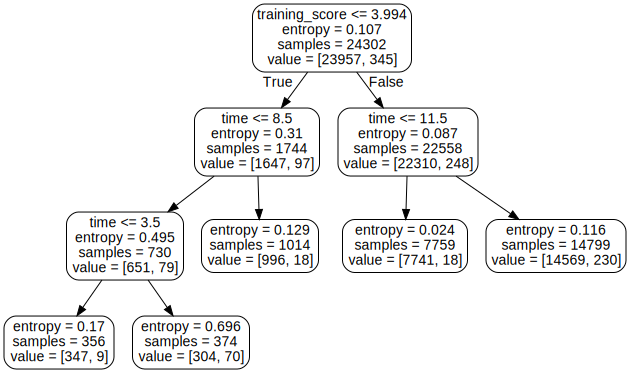

In [22]:
decision_tree = graphviz.Source( tree.export_graphviz(dt, out_file=None, feature_names=X_train.columns, filled=False, rounded=True,impurity=True))
decision_tree

##### Visualizations: ROC Curve

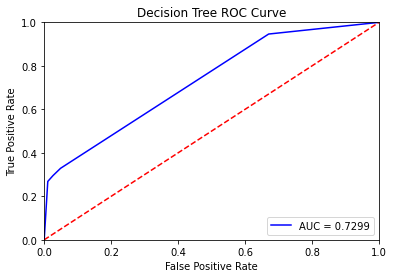

In [23]:
plot_roc(decisiontree_test_pred,y_test,"Decision Tree ROC Curve",pos_label="1 Left")

##### Variable Importance (Feature Importance)

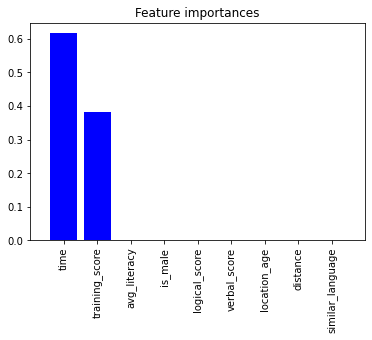

In [24]:
importances = dt.feature_importances_

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances,
       color="b", align="center")
plt.xticks(range(X.shape[1]), cols,rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

##### Visualizations: Partial Dependence Plot

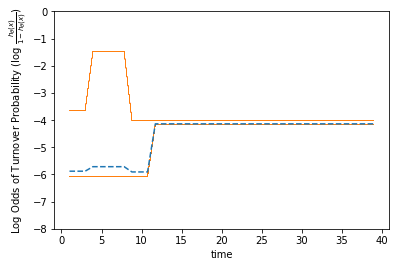

In [25]:
pdplot(X=X_train,var_name='time',n=500,model=dt,which_class = 1)

##### Visualizations: Two-way Partial Dependence Plot

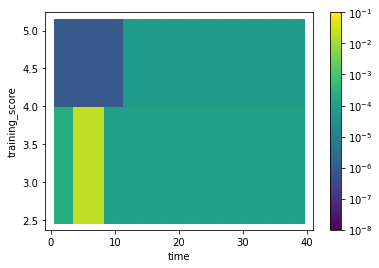

In [26]:
plot_twoway_pdp(X=X_train, model=dt,
             var1_name='time',var2_name='training_score',
             var2_min=2.5,which_class=1)

### Random Forest

Using `RandomizedSearchCV` we try many hyperparameter combinations

In [27]:
#Make a dictionary of which combinations of hyperparameters to try
random_grid = {'criterion': ['entropy'],
               'max_depth': np.unique( np.exp(np.linspace(0, 10, 100)).astype(int) ),
               'min_samples_leaf': np.unique( np.exp(np.linspace(0, 8, 100)).astype(int) ),
               'max_features': [None,'auto','log2'],
               'min_impurity_decrease': np.exp(np.linspace(-9, -1, 100))}

In [28]:
rf_random_search = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators=100), 
                                      param_distributions = random_grid,
                                      random_state=345, n_iter = 100,
                                      scoring='neg_log_loss',n_jobs=-1,
                                      cv =folds,return_train_score=True)
rf_random_search.fit(X=X_train,y=y_train)
rf_random_search.best_params_

{'min_samples_leaf': 41,
 'min_impurity_decrease': 0.00048747935055342144,
 'max_features': None,
 'max_depth': 6,
 'criterion': 'entropy'}

We set the model using the parameters that returned the best results.

In [29]:
rf = rf_random_search.best_estimator_

Find the cross validation scores (these will be plotted at the end)

In [30]:
best_model_index = rf_random_search.best_index_
rf_train_score = rf_random_search.cv_results_['mean_train_score'][best_model_index]
rf_validation_score = rf_random_search.cv_results_['mean_test_score'][best_model_index]
rf_train_std = rf_random_search.cv_results_['std_train_score'][best_model_index]
rf_validation_std = rf_random_search.cv_results_['std_test_score'][best_model_index]

Make predictions on the holdout test set

In [31]:
randomforest_test_pred = rf.predict_proba(X_test)[:,1]

Evaluate the test loss

In [32]:
test_loss_rf = log_loss(y_test.values,randomforest_test_pred)
print("Test Loss: %0.4f" % test_loss_rf)

Test Loss: 0.0648


##### Visualizations: ROC Curve

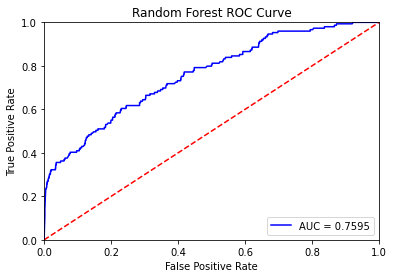

In [33]:
plot_roc(randomforest_test_pred,y_test,"Random Forest ROC Curve",pos_label="1 Left")

##### Variable Importance (Feature Importance)

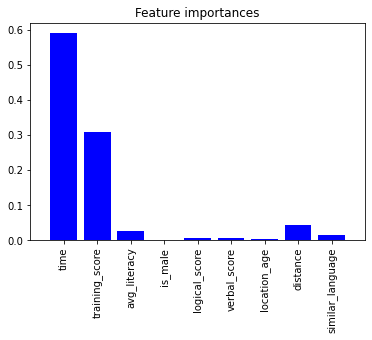

In [34]:
importances = rf.feature_importances_

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances,
       color="b", align="center")
plt.xticks(range(X.shape[1]), cols,rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

##### Visualizations: Partial Dependence Plot

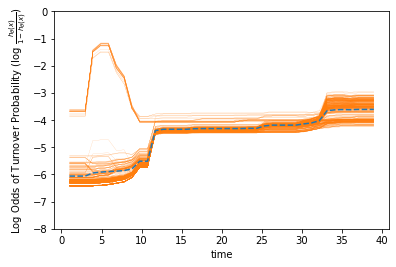

In [35]:
pdplot(X=X_train,var_name='time',n=500,model=rf,which_class = 1)

##### Visualizations: Two-way Partial Dependence Plot

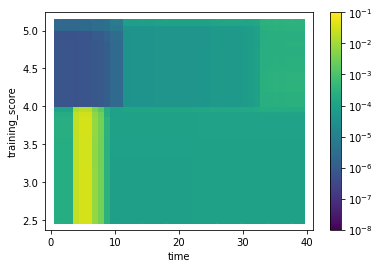

In [36]:
plot_twoway_pdp(X=X_train, model=rf,
             var1_name='time',var2_name='training_score',
             var2_min=2.5,which_class=1)

### Neural Network

Neural networks perform better with standardized variable scaling. In cross-validation, variables should be rescaled using the training set within each fold, so rather than scaling the data before cross-validation, we add scaling as a pre-step to fitting the model in a pipeline using the `make_pipeline` function. Now when we fit the model using the pipeline, it will first standardize the variables using `scaler` before fitting the model `nnet`.

In [37]:
nnet = MLPClassifier(random_state=345,max_iter=100)
scaler = StandardScaler()
nnet_pipeline = make_pipeline(scaler,nnet)

Using `RandomizedSearchCV` we can try many hyperparameter combinations and select the best performing combination. When using a pipeline, we have to specify to which step the hyperparameters belong. For example rather than writing `'hidden_layer_sizes'` we write `'mlpclassifier__hidden_layer_sizes'` to denote that hidden layer size parameter belongs to the classifier and not the scaler.

In [38]:
#Make a dictionary of which combinations of hyperparameters to try
random_grid = {'mlpclassifier__solver': ['adam'],
               'mlpclassifier__activation': ['tanh','relu','logistic'],
               'mlpclassifier__alpha': [0.01,0.05],
               'mlpclassifier__hidden_layer_sizes': [(30,20,10),(20,20),(25,15),(10,40,10),(20,20,20),(30,10)]}

In [39]:
# #Commented out for speed
# nnet_random_search = RandomizedSearchCV(estimator = nnet_pipeline, 
#                                       param_distributions = random_grid, n_iter = 25,
#                                       #random_state=345, 
#                                       scoring='neg_log_loss',n_jobs=-1,
#                                       cv =folds,return_train_score=True)
# nnet_random_search.fit(X=X_train,y=y_train)
# nnet_random_search.best_params_

Use the model which returned the best results (slightly modified the hidden layer sizes from (30,10) to (32,12))

In [40]:
nnet = MLPClassifier(solver='adam', 
                     activation='tanh',
                     alpha=1e-2, 
                     hidden_layer_sizes=(32,12), 
                     random_state=345)
nnet_pipeline = make_pipeline(scaler,nnet)

Find the cross validation scores (these will be plotted at the end)

In [41]:
cv_results_nnet = cross_validate(
    estimator=nnet_pipeline,
    X=X_train,
    y=y_train,
    cv=folds,
    scoring='neg_log_loss',
    return_train_score=True
)
cv_val_score_nnet = -cv_results_nnet['test_score'].mean()

print("Mean cross-validation score (log loss) for neural network model: %0.4f" % cv_val_score_nnet)

Mean cross-validation score (log loss) for neural network model: 0.0706


Make predictions on the holdout test set

In [42]:
nnet_pipeline.fit(X_train,y_train)
nnet_test_pred = nnet_pipeline.predict_proba(X_test)[:,1]

Evaluate the test loss

In [43]:
test_loss_nnet = log_loss(y_test.values,nnet_test_pred)
print("Test Loss: %0.4f" % test_loss_nnet)

Test Loss: 0.0703


##### Visualizations: ROC Curve

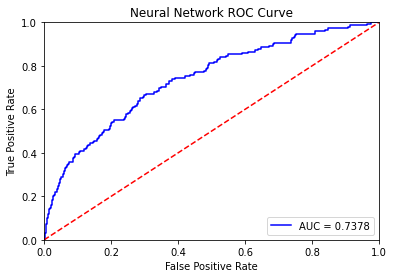

In [44]:
plot_roc(nnet_test_pred,y_test,"Neural Network ROC Curve",pos_label="1 Left")

##### Variable Importance (Feature Importance)

Neural networks don't have an intrinsic variable importance like decision trees and random forests. However, if you want an interpretation of variable importance for neural nets, there are alternative packages that can help (e.g. the`LIME` package)

##### Visualizations: Partial Dependence Plot

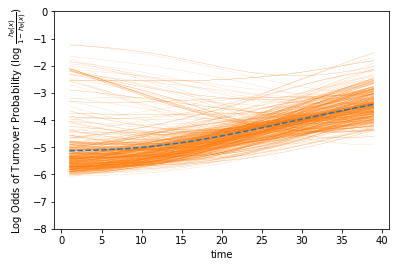

In [45]:
pdplot(X=X_train,var_name='time',n=500,model=nnet_pipeline,which_class = 1)

##### Visualizations: Two-way Partial Dependence Plot

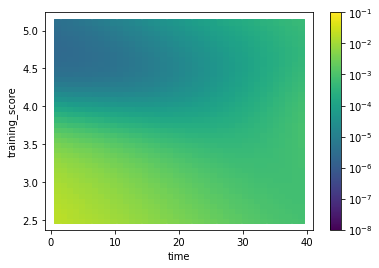

In [46]:
plot_twoway_pdp(X=X_train, model=nnet_pipeline,
             var1_name='time',var2_name='training_score',
             var2_min=2.5,which_class=1)

### Logistic Regression


In our logistic regression we include time fixed effects. So we add a preprocessing step that uses `OneHotEncoder()` to transform `time` into a dummy variable for each month.
  
The default for `sklearn.linear_model.LogisticRegression` is to include the L2 regularization term, and it isn't possible to entirely exclude a regularization term. To replicate a traditional logistic regression model with no regularization (like logit in Stata), set the parameter `C` to a very high number to make the strength of the L2 regularization term essentially zero (smaller values of `C` specify stronger regularization).

In [47]:
preprocess = make_column_transformer(
    (OneHotEncoder(), ["time"]),
remainder="passthrough")

logistic = LogisticRegression(C=1e8)

logistic_pipeline = make_pipeline(
    preprocess,
    logistic)

Find the cross validation scores (these will be plotted at the end)

In [48]:
cv_results_logistic = cross_validate(
    estimator=logistic_pipeline,
    X=X_train,
    y=y_train,
    cv=folds,
    scoring='neg_log_loss',
    return_train_score=True
)
cv_val_score_logistic = -cv_results_logistic['test_score'].mean()

print("Mean cross-validation score (log loss) for logistic model: %0.4f" % cv_val_score_logistic)

Mean cross-validation score (log loss) for logistic model: 0.0709


Fit the model using the training data, and use it to make predictions on the holdout test set

In [49]:
logistic_pipeline.fit(X_train,y_train)
logistic_test_pred = logistic_pipeline.predict_proba(X_test)[:,1]

print("Test Loss: %0.4f" % log_loss(y_test.values,logistic_test_pred))

Test Loss: 0.0699


#### Visualizations

##### Visualizations: ROC Curve

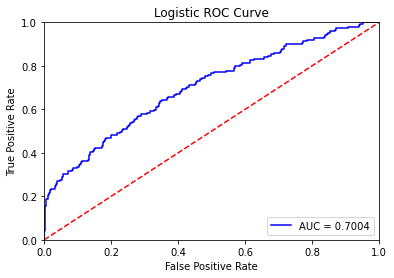

In [50]:
plot_roc(logistic_test_pred,y_test,"Logistic ROC Curve",pos_label="1 Left")

##### Visualizations: Partial Dependence Plot

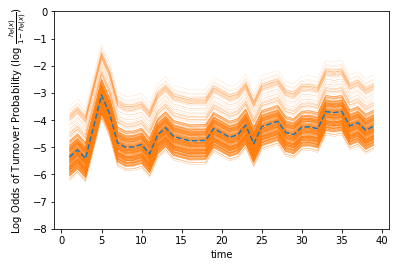

In [51]:
#Note since the variable time is categorical in our logistic_pipeline model, we set categorical_var=True in the pdplot function
pdplot(X=X_train,var_name='time',categorical_var=True,n=500,model=logistic_pipeline)

##### Visualizations: Two-way Partial Dependence Plot

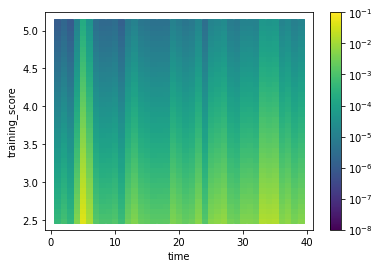

In [52]:
#Note since the variable time is categorical in our logistic_pipeline model, we set categorical_var1=True in the plot_twoway_pdp function
plot_twoway_pdp(X=X_train, model=logistic_pipeline,
             var1_name='time',var2_name='training_score',categorical_var1=True,
             var2_min=2.5,which_class=1)

# Plots that compare training to test loss for all the models

Plot the cross validation loss for the training and holdout test set on the x and y axis, respectively. Error bars represent standard deviation variance yielded by the k-folds cross-validation.

In [53]:
x=[-dt_train_score,-rf_train_score,-cv_results_nnet['train_score'].mean(),-cv_results_logistic['train_score'].mean()]
x_err=[dt_train_std,rf_train_std,np.std(cv_results_nnet['train_score']),np.std(cv_results_logistic['train_score'])]
y=[-dt_validation_score,-rf_validation_score,-cv_results_nnet['test_score'].mean(),-cv_results_logistic['test_score'].mean()]
y_err=[dt_validation_std,rf_validation_std,np.std(cv_results_nnet['test_score']),np.std(cv_results_logistic['test_score'])]

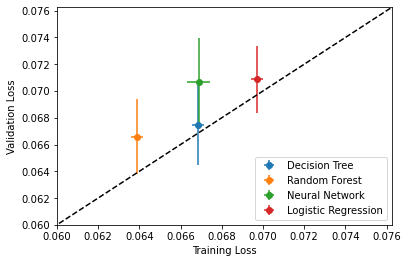

In [54]:
plt.plot([-1,1],[-1,1], c='k', marker='None',linestyle='--',label='_nolegend_')
for ax, ax_err, ay, ay_err in zip(x, x_err, y, y_err):
    plt.errorbar(ax, ay, xerr=ax_err, yerr=ay_err, label='Training',marker='o', linestyle='None')
plt.xlim(0.06,0.07625)
plt.ylim(0.06,0.07625)
plt.xlabel('Training Loss')
plt.ylabel('Validation Loss')
plt.legend(['Decision Tree','Random Forest','Neural Network','Logistic Regression'], loc=4)

Now plot the cross validation loss *relative to the logistic regression model* for the training and holdout test set on the x and y axis, respectively. Error bars represent standard deviation variance yielded by the k-folds cross-validation.

In [55]:
x=[-(dt_train_score-cv_results_logistic['train_score'].mean()),-(rf_train_score-cv_results_logistic['train_score'].mean()),-(cv_results_nnet['train_score'].mean()-cv_results_logistic['train_score'].mean()),0]
x_err=[np.std(dt_train_std-cv_results_logistic['train_score']),np.std(rf_train_std-cv_results_logistic['train_score']),np.std(cv_results_nnet['train_score']-cv_results_logistic['train_score']),0]
y=[-(dt_validation_score-cv_results_logistic['test_score'].mean()),-(rf_validation_score-cv_results_logistic['test_score'].mean()),-(cv_results_nnet['test_score'].mean()-cv_results_logistic['test_score'].mean()),0]
y_err=[np.std(dt_validation_std-cv_results_logistic['test_score']),np.std(rf_validation_std-cv_results_logistic['test_score']),np.std(cv_results_nnet['test_score']-cv_results_logistic['test_score']),0]

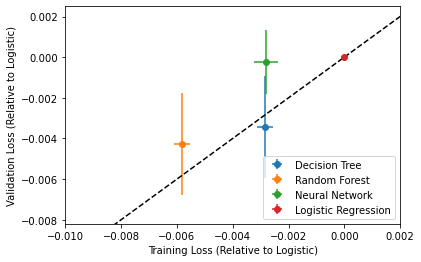

In [56]:
plt.plot([-1,1],[-1,1], c='k', marker='None',linestyle='--',label='_nolegend_')
for ax, ax_err, ay, ay_err in zip(x, x_err, y, y_err):
    plt.errorbar(ax, ay, xerr=ax_err, yerr=ay_err, label='Training',marker='o', linestyle='None')
plt.xlim(-0.010,0.002)
plt.ylim(-0.0082,0.0025)
plt.xlabel('Training Loss (Relative to Logistic)')
plt.ylabel('Validation Loss (Relative to Logistic)')
plt.legend(['Decision Tree','Random Forest','Neural Network','Logistic Regression'], loc=4)